# SMS Spam Detection

Import Modules

In [156]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from nltk.corpus import words
from tqdm.notebook import tqdm
from symspellpy import SymSpell

Read the dataset into a Pandas DataFrame

In [157]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.drop_duplicates()
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Exploratory Data Analysis

In [72]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


c:\Users\dtren\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


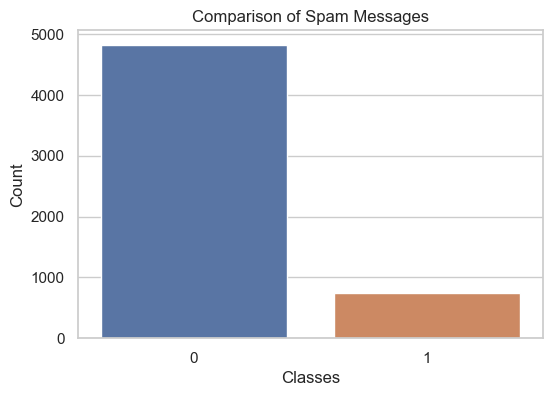

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

ax = sns.countplot(df.label)

# Add labels and title
ax.set_xlabel("Classes")
ax.set_ylabel("Count")
ax.set_title("Comparison of Spam Messages")

# Show the plot
plt.show()

In [158]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
tqdm.pandas(desc='My bar!')
df["length"] = df["message"].progress_apply(len)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


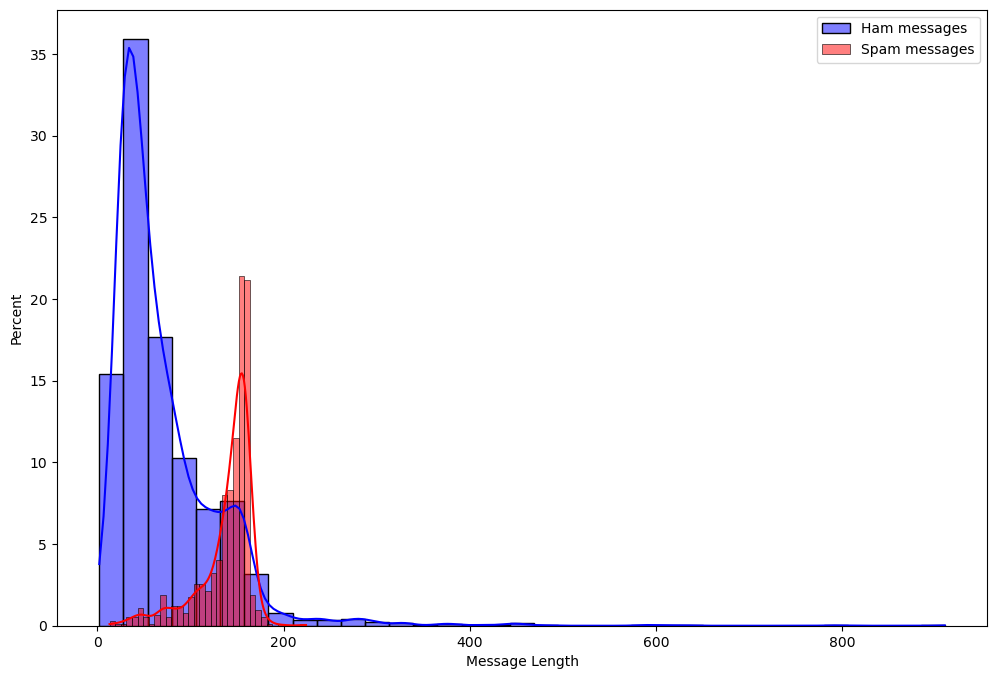

In [4]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["length"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["length"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Message Length")
plt.show()


In [75]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["length"], spam_data["length"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.6784415728544576
P-Value: 8.17299035435783e-290
The distributions are significantly different.


In [159]:
def count_words(text):
    return len(text.split(" "))
tqdm.pandas(desc='My bar!')
df["word_count"] = df["message"].progress_apply(count_words)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count
0,0,"Go until jurong point, crazy.. Available only ...",111,20
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,0,U dun say so early hor... U c already then say...,49,11
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,30
5568,0,Will Ì_ b going to esplanade fr home?,37,8
5569,0,"Pity, * was in mood for that. So...any other s...",57,10
5570,0,The guy did some bitching but I acted like i'd...,125,26


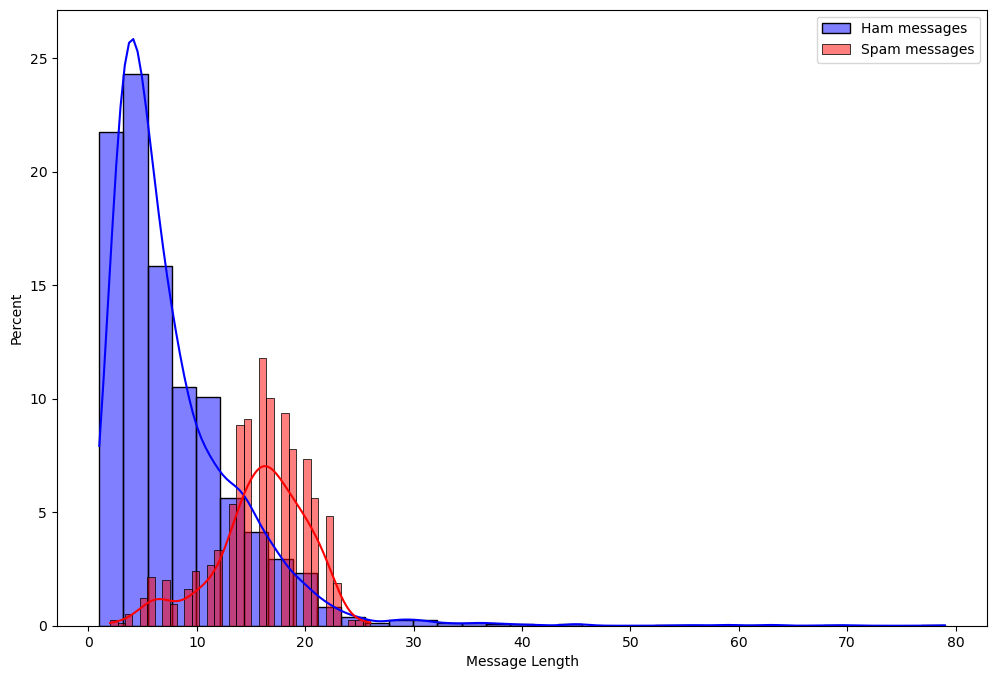

In [93]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["word_count"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["word_count"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Message Length")
plt.show()


In [103]:
df[(df["label"] == 0) & (df["word_count"] > 30)]["word_count"].describe()

count    40.000000
mean     42.250000
std      12.751571
min      31.000000
25%      33.000000
50%      37.000000
75%      45.000000
max      79.000000
Name: word_count, dtype: float64

In [97]:
df[df["label"] == 1]["word_count"].describe()

count    747.000000
mean      15.914324
std        4.268237
min        2.000000
25%       14.000000
50%       16.000000
75%       19.000000
max       26.000000
Name: word_count, dtype: float64

In [99]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["word_count"], spam_data["word_count"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.655595091939433
P-Value: 3.5795873231440907e-268
The distributions are significantly different.


In [160]:
def count_symbols(message):
    symbols = set(string.punctuation)
    count = sum(1 for char in message if char in symbols)
    return count / len(message)

df["symbols"] = df["message"].apply(count_symbols)
df

,label,message,length,word_count,symbols
0,0,"Go until jurong point, crazy.. Available only ...",111,20,0.081081
1,0,Ok lar... Joking wif u oni...,29,6,0.206897
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,0.038710
3,0,U dun say so early hor... U c already then say...,49,11,0.122449
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,0.032787
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,30,0.049689
5568,0,Will Ì_ b going to esplanade fr home?,37,8,0.054054
5569,0,"Pity, * was in mood for that. So...any other s...",57,10,0.122807
5570,0,The guy did some bitching but I acted like i'd...,125,26,0.008000


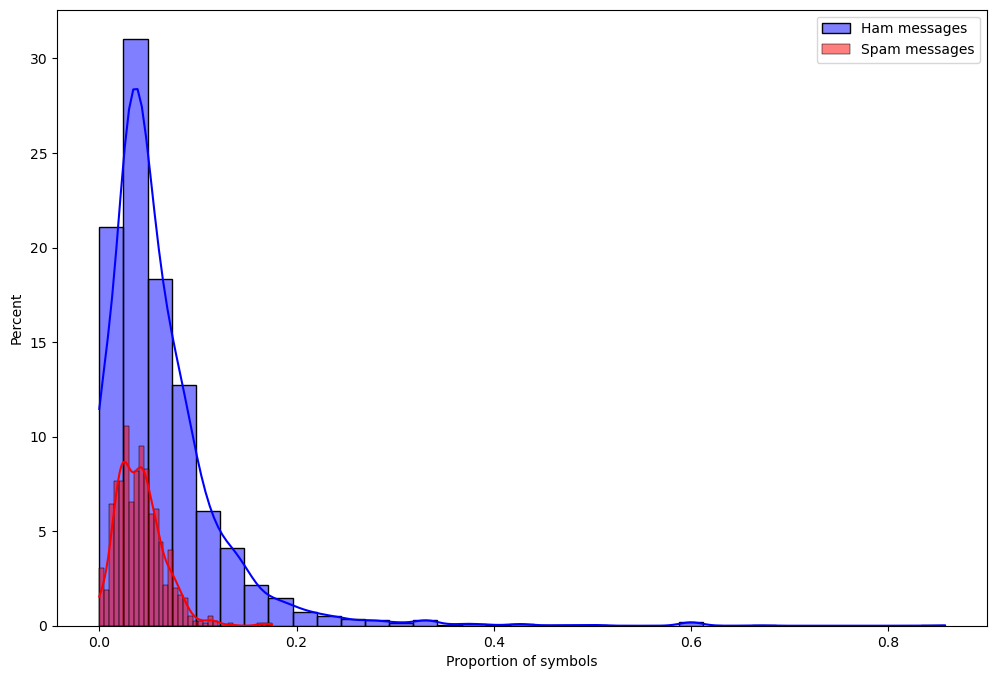

In [77]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["symbols"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["symbols"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of symbols")
plt.show()


In [78]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["symbols"], spam_data["symbols"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.21631201836707797
P-Value: 5.046492269780785e-27
The distributions are significantly different.


In [161]:
def count_capitals(message):
    count = sum(1 for char in message if char.isupper())
    return count / len(message)

tqdm.pandas()
df["capitals"] = df["message"].apply(count_capitals)
df

,label,message,length,word_count,symbols,capitals
0,0,"Go until jurong point, crazy.. Available only ...",111,20,0.081081,0.027027
1,0,Ok lar... Joking wif u oni...,29,6,0.206897,0.068966
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,0.038710,0.064516
3,0,U dun say so early hor... U c already then say...,49,11,0.122449,0.040816
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,0.032787,0.032787
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,30,0.049689,0.055901
5568,0,Will Ì_ b going to esplanade fr home?,37,8,0.054054,0.054054
5569,0,"Pity, * was in mood for that. So...any other s...",57,10,0.122807,0.035088
5570,0,The guy did some bitching but I acted like i'd...,125,26,0.008000,0.016000


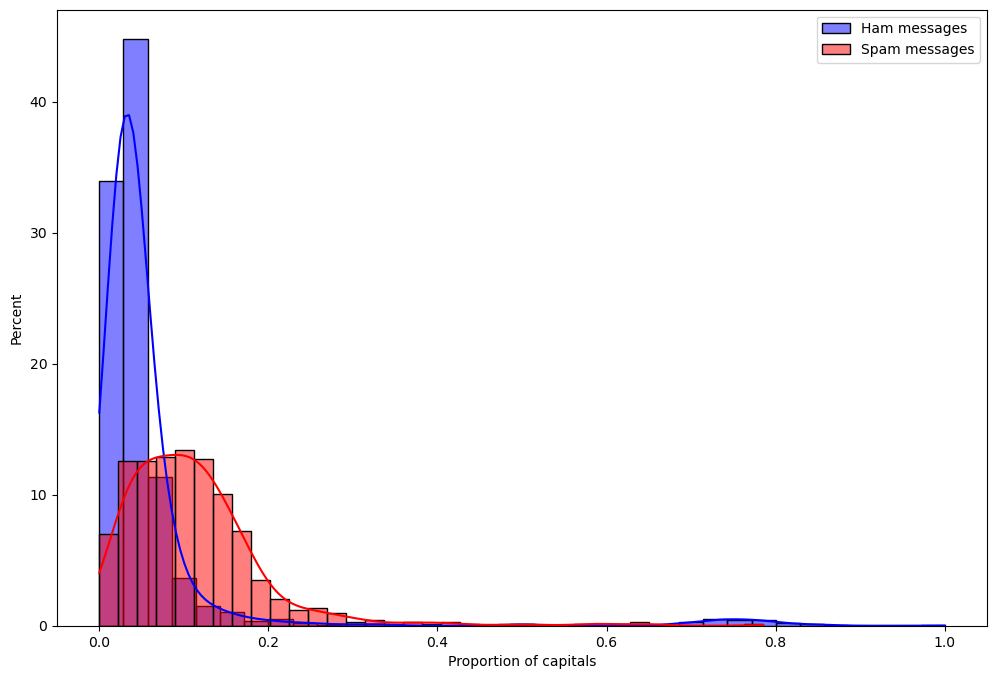

In [80]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["capitals"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["capitals"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of capitals")
plt.show()


In [81]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["capitals"], spam_data["capitals"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.5352696450742521
P-Value: 4.415291113781373e-172
The distributions are significantly different.


In [82]:
df[df["label"] == 1]

,label,message,length,symbols,capitals
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.038710,0.064516
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,0.054054,0.047297
8,1,WINNER!! As a valued network customer you have...,158,0.037975,0.075949
9,1,Had your mobile 11 months or more? U R entitle...,154,0.012987,0.090909
11,1,"SIX chances to win CASH! From 100 to 20,000 po...",136,0.058824,0.125000
...,...,...,...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,90,0.033333,0.188889
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,0.031250,0.650000
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,160,0.050000,0.125000
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,147,0.020408,0.095238


In [162]:
def process_text(message):
    message = "".join([char for char in message if char not in string.punctuation]).lower()
    STOPWORDS  = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    return ' '.join([word for word in message.split() if word not in STOPWORDS])
df["message"] = df["message"].apply(process_text)
df

,label,message,length,word_count,symbols,capitals
0,0,go jurong point crazy available bugis n great ...,111,20,0.081081,0.027027
1,0,ok lar joking wif oni,29,6,0.206897,0.068966
2,1,free entry wkly comp win fa cup final tkts 21s...,155,28,0.038710,0.064516
3,0,dun say early hor c already say,49,11,0.122449,0.040816
4,0,nah think goes usf lives around though,61,13,0.032787,0.032787
...,...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,30,0.049689,0.055901
5568,0,ì b going esplanade fr home,37,8,0.054054,0.054054
5569,0,pity mood soany suggestions,57,10,0.122807,0.035088
5570,0,guy bitching acted like id interested buying s...,125,26,0.008000,0.016000


FAILED ATTEMPT

In [84]:
def freq_incorrect(text):
    WORDS = text.split(" ")
    english_vocab = set(w.lower() for w in words.words())
    misspelled = len([word for word in WORDS if word not in english_vocab])
    return misspelled / len(WORDS)

#tqdm.pandas(desc='My bar!')
#df["misspelt"] = df["message"].progress_apply(freq_incorrect)
#df

DO NOT RUN

In [85]:
from nltk.corpus import brown
from collections import Counter
import os

# Download the Brown corpus (if not already downloaded)
nltk.download('brown')

# Access the Brown corpus
brown_words = brown.words()

# Calculate word frequencies
word_freq = Counter(brown_words)

# Sort the words by frequency
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

file_path = "custom_frequency_dictionary.txt"
# Create a custom frequency dictionary file
if not os.path.exists(file_path):
    with open(file_path, "w") as f:
        for word, freq in sorted_word_freq:
            f.write(f"{word} {freq}\n")


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\dtren\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [87]:
def freq_incorrect(text):
    WORDS = text.split(" ")
    sym_spell = SymSpell()
    max_edit_distance = 1
    sym_spell.load_dictionary("custom_frequency_dictionary.txt", term_index=0, count_index=1)
    misspelled = sum(map(lambda word: 1 if len([obj.term for obj in sym_spell.lookup(word, max_edit_distance) if obj.term != word]) > 0 else 0, WORDS))

    return misspelled / len(WORDS)

tqdm.pandas(desc='My bar!')
df["misspelt"] = df["message"].progress_apply(freq_incorrect)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,symbols,capitals,misspelt
0,0,go jurong point crazy available bugis n great ...,111,0.081081,0.027027,0.312500
1,0,ok lar joking wif oni,29,0.206897,0.068966,0.800000
2,1,free entry wkly comp win fa cup final tkts 21s...,155,0.038710,0.064516,0.454545
3,0,dun say early hor c already say,49,0.122449,0.040816,0.285714
4,0,nah think goes usf lives around though,61,0.032787,0.032787,0.285714
...,...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,0.049689,0.055901,0.187500
5568,0,ì b going esplanade fr home,37,0.054054,0.054054,0.333333
5569,0,pity mood soany suggestions,57,0.122807,0.035088,0.250000
5570,0,guy bitching acted like id interested buying s...,125,0.008000,0.016000,0.142857


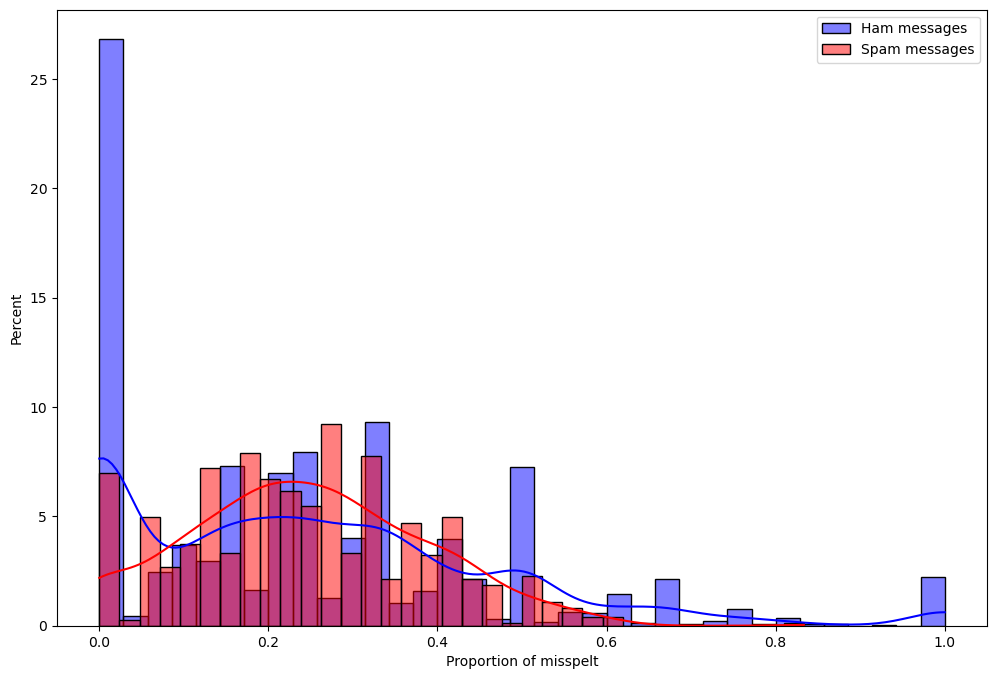

In [88]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["misspelt"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["misspelt"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of misspelt")
plt.show()

In [89]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["misspelt"], spam_data["misspelt"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.20023277913033827
P-Value: 3.438413810862978e-23
The distributions are significantly different.


In [50]:
df[df["label"] == 0]["length"].describe()

count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: length, dtype: float64

In [163]:
from nltk.stem.porter import PorterStemmer

def stemming(text):
    port_stem = PorterStemmer()
    text = [port_stem.stem(word) for word in text.split(" ") if word not in stopwords.words('english')]
    return " ".join(text)


tqdm.pandas(desc='My bar!')
df["message"] = df["message"].progress_apply(stemming)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals
0,0,go jurong point crazi avail bugi n great world...,111,20,0.081081,0.027027
1,0,ok lar joke wif oni,29,6,0.206897,0.068966
2,1,free entri wkli comp win fa cup final tkt 21st...,155,28,0.038710,0.064516
3,0,dun say earli hor c alreadi say,49,11,0.122449,0.040816
4,0,nah think goe usf live around though,61,13,0.032787,0.032787
...,...,...,...,...,...,...
5567,1,2nd time tri contact å£750 pound prize claim e...,161,30,0.049689,0.055901
5568,0,ì b go esplanad fr home,37,8,0.054054,0.054054
5569,0,piti mood soani suggest,57,10,0.122807,0.035088
5570,0,guy bitch act like id interest buy someth els ...,125,26,0.008000,0.016000


Tokenisation

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

df['tokens'] = df['message'].apply(word_tokenize)

In [247]:
vocab_list = list(chain(*df["tokens"].tolist()))
counter = Counter(vocab_list)
counter

Counter({'call': 653,
         'go': 449,
         'get': 447,
         'come': 297,
         'ok': 277,
         'ltgt': 276,
         'free': 275,
         'know': 270,
         'like': 255,
         'got': 250,
         'love': 244,
         'want': 243,
         'day': 241,
         'ill': 239,
         'time': 238,
         'good': 235,
         'text': 224,
         'send': 204,
         'need': 186,
         'one': 180,
         'txt': 176,
         'see': 171,
         'today': 169,
         'think': 166,
         'home': 162,
         'take': 160,
         'lor': 160,
         'repli': 159,
         'stop': 158,
         'tell': 156,
         'sorri': 156,
         'still': 153,
         'r': 153,
         'back': 152,
         'mobil': 150,
         'make': 147,
         'n': 143,
         'phone': 141,
         'say': 138,
         'new': 136,
         'week': 134,
         'work': 134,
         'pleas': 134,
         'later': 134,
         'well': 133,
         'da': 132,
 

Cool Visualisation

<function matplotlib.pyplot.show(close=None, block=None)>

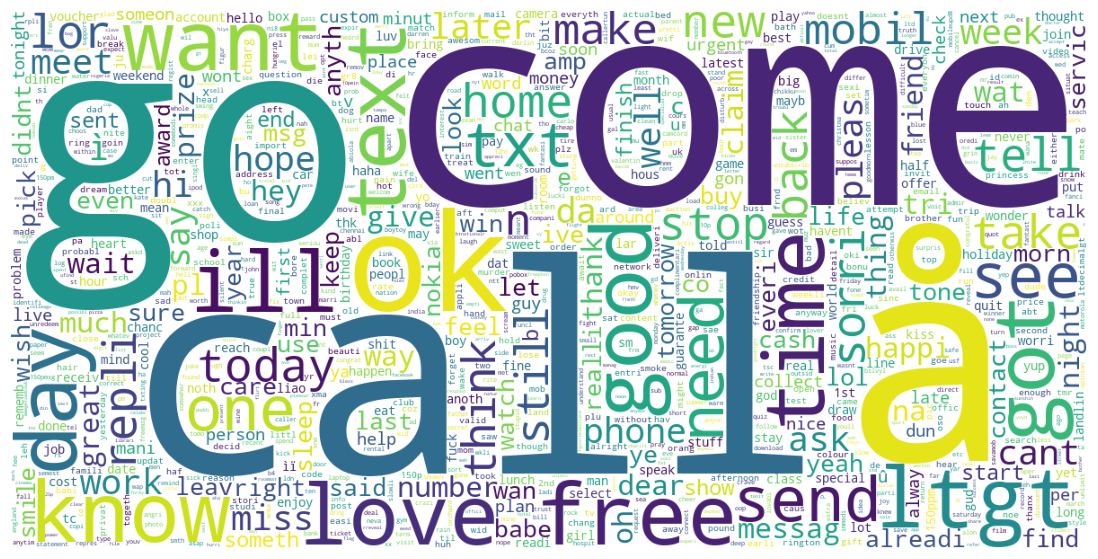

In [248]:
from itertools import chain
from collections import Counter
from wordcloud import WordCloud


wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)
wc.generate(' '.join(vocab_list))

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

and Word Embeddings

In [164]:
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

df['tokens'] = df['message'].apply(word_tokenize)
X = df[[i for i in df.columns if i != "label"]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train

,message,length,word_count,symbols,capitals,tokens
1642,sleep nt feel well,24,4,0.000000,0.041667,"[sleep, nt, feel, well]"
2899,come aftr ltdecimalgt clean hous,55,10,0.109091,0.145455,"[come, aftr, ltdecimalgt, clean, hous]"
480,almost see sec,28,7,0.035714,0.035714,"[almost, see, sec]"
3485,yeah probabl earlier,32,5,0.031250,0.031250,"[yeah, probabl, earlier]"
157,hello love get interview today happi good boy ...,157,33,0.050955,0.044586,"[hello, love, get, interview, today, happi, go..."
...,...,...,...,...,...,...
905,hey what charl sorri late repli,49,9,0.040816,0.020408,"[hey, what, charl, sorri, late, repli]"
5192,oh oh den muz chang plan liao go back yan jiu,69,14,0.130435,0.043478,"[oh, oh, den, muz, chang, plan, liao, go, back..."
3980,huh cant thk oredi mani page,55,13,0.018182,0.018182,"[huh, cant, thk, oredi, mani, page]"
235,print oh ltgt come upstair,50,11,0.120000,0.040000,"[print, oh, ltgt, come, upstair]"


FAILED APPROACH

In [20]:
import gensim.models.keyedvectors as word2vec
from gensim import models
# Load the pre-trained Word2Vec model (replace with your model file)

word2vec_model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
embedding_dim = 50

TENTATIVE MAY NOT USE

In [31]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load("word2vec-google-news-300.model")

KeyboardInterrupt: 

In [194]:
X_train_corpus = X_train["tokens"].tolist()
X_test_corpus = X_test["tokens"].tolist()
w2v_model = models.Word2Vec(vector_size=300, window=3, min_count=5, workers=8)
w2v_model.build_vocab(X_train_corpus)
words = w2v_model.wv
vocab_size = len(words)
print("Vocab size", vocab_size)
w2v_model.train(X_train_corpus,total_examples=len(X_train_corpus),epochs=32)


Vocab size 1371


(886602, 1269088)

In [195]:
w2v_model.wv.most_similar("lol")

[('rememb', 0.9570707678794861),
 ('fine', 0.9530873894691467),
 ('fuck', 0.9512888789176941),
 ('everyth', 0.9506617188453674),
 ('shit', 0.9377082586288452),
 ('piss', 0.9315388798713684),
 ('idea', 0.9312214851379395),
 ('would', 0.9295352101325989),
 ('fall', 0.9294281005859375),
 ('guy', 0.9292007088661194)]

In [196]:
max_len = X_train["tokens"].apply(lambda x: len(x)).max()

In [224]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train_corpus)

tokenized_train = tokenizer.texts_to_sequences(X_train_corpus)
tokenized_test = tokenizer.texts_to_sequences(X_test_corpus)

train_x = sequence.pad_sequences(tokenized_train, maxlen = max_len)
test_x = sequence.pad_sequences(tokenized_test, maxlen = max_len)
train_x.shape

(4457, 79)

In [198]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7179

In [84]:
train_x

array([[   0,    0,    0, ...,  635,   79,   40],
       [   0,    0,    0, ...,  424,  745,  288],
       [   0,    0,    0, ...,  593,   20, 1014],
       ...,
       [   0,    0,    0, ...,  814,  144,  780],
       [   0,    0,    0, ...,    7,    4, 7178],
       [   0,    0,    0, ...,  109,  226,  141]])

In [80]:
tokenizer.word_index.items()

dict_items([('call', 1), ('go', 2), ('get', 3), ('come', 4), ('know', 5), ('ok', 6), ('ltgt', 7), ('free', 8), ('like', 9), ('got', 10), ('want', 11), ('ill', 12), ('day', 13), ('good', 14), ('love', 15), ('time', 16), ('text', 17), ('send', 18), ('need', 19), ('see', 20), ('one', 21), ('lor', 22), ('today', 23), ('think', 24), ('back', 25), ('txt', 26), ('take', 27), ('still', 28), ('tell', 29), ('stop', 30), ('sorri', 31), ('repli', 32), ('r', 33), ('mobil', 34), ('pleas', 35), ('home', 36), ('make', 37), ('say', 38), ('work', 39), ('well', 40), ('new', 41), ('week', 42), ('n', 43), ('phone', 44), ('later', 45), ('cant', 46), ('meet', 47), ('ask', 48), ('hi', 49), ('give', 50), ('ì', 51), ('da', 52), ('tri', 53), ('much', 54), ('night', 55), ('miss', 56), ('wait', 57), ('happi', 58), ('thank', 59), ('hope', 60), ('oh', 61), ('thing', 62), ('way', 63), ('great', 64), ('wat', 65), ('claim', 66), ('messag', 67), ('pl', 68), ('na', 69), ('hey', 70), ('dear', 71), ('number', 72), ('friend

In [90]:
len(tokenizer.word_index)

7178

In [117]:
from itertools import chain
flattened_list = list(chain(*X_train_corpus))
[True if "interview" in flattened_list else False]

[True]

In [118]:
[True if "interview" in tokenizer.word_index.keys() else False]

[True]

In [120]:
[True if "interview" in w2v_model.wv.index_to_key else False]

[False]

In [122]:
len(w2v_model.wv.index_to_key)

1371

In [136]:
w2v_model.wv["hi"].shape

(100,)

Some words may not be found because we set min_count = 5 for w2v_model

In [200]:
# Build Embedding Layer
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))
print(embedding_matrix)
for word, i in tqdm(tokenizer.word_index.items()):
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/7178 [00:00<?, ?it/s]

(7179, 300)


In [138]:
vocab_size

7179

In [201]:
from keras.layers import Activation, Dense, Dropout, Embedding
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [202]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [153]:
X_train

,message,length,word_count,words,symbols,capitals,tokens
1642,sleep nt feel well,24,4,4,0.000000,0.041667,"[sleep, nt, feel, well]"
2899,come aftr ltdecimalgt clean hous,55,10,10,0.109091,0.145455,"[come, aftr, ltdecimalgt, clean, hous]"
480,almost see sec,28,7,7,0.035714,0.035714,"[almost, see, sec]"
3485,yeah probabl earlier,32,5,5,0.031250,0.031250,"[yeah, probabl, earlier]"
157,hello love get interview today happi good boy ...,157,33,33,0.050955,0.044586,"[hello, love, get, interview, today, happi, go..."
...,...,...,...,...,...,...,...
905,hey what charl sorri late repli,49,9,9,0.040816,0.020408,"[hey, what, charl, sorri, late, repli]"
5192,oh oh den muz chang plan liao go back yan jiu,69,14,14,0.130435,0.043478,"[oh, oh, den, muz, chang, plan, liao, go, back..."
3980,huh cant thk oredi mani page,55,13,13,0.018182,0.018182,"[huh, cant, thk, oredi, mani, page]"
235,print oh ltgt come upstair,50,11,11,0.120000,0.040000,"[print, oh, ltgt, come, upstair]"


In [203]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, Flatten, BatchNormalization

# Input for text data
text_input = Input(shape=(max_len,), name='text_input')
embedded_sequences = embedding_layer(text_input)
conv1D_layer = Conv1D(filters=64, kernel_size=3, padding='same')(embedded_sequences)
batch_norm_layer = BatchNormalization()(conv1D_layer)
activation_layer = Activation('relu')(batch_norm_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1D_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(maxpooling_layer)

# Input for additional features
additional_features = [i for i in X_train.columns if i not in ["message", "tokens"]]
num_features = len(additional_features)
x_train_features = X_train[additional_features]
feature_input = Input(shape=(num_features,), name='feature_input')

# Concatenate the LSTM output and feature input
merged_layer = concatenate([lstm_layer, feature_input])

# Dense layers for further processing
dense_layer1 = Dense(64, activation='relu')(merged_layer)
dropout_layer = Dropout(0.5)(dense_layer1)

# Output layer
output_layer = Dense(1, activation='sigmoid', name='output')(dropout_layer)

# Create the model
model = Model(inputs=[text_input, feature_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 79)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 79, 300)              2153700   ['text_input[0][0]']          
                                                                                                  
 conv1d_4 (Conv1D)           (None, 79, 64)               57664     ['embedding_4[0][0]']         
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 39, 64)               0         ['conv1d_4[0][0]']            
 g1D)                                                                                       

Dont think I will use

In [140]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
model = Sequential()

# Add the embedding layer
model.add(embedding_layer)

# Add a 1D Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add LSTM layer(s)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Add Dense layer(s)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], class_weight=dict(enumerate(class_weights)))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          717900    
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 760205 (2.90 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 717900 (2.74 MB)
_________________________________________________________________


In [204]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [209]:
%%time
history = model.fit([train_x, x_train_features], y_train,
                    batch_size=32,
                    epochs=16,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/16
63/63 [==============================] - 8s 128ms/step - loss: 0.0350 - accuracy: 0.9925 - val_loss: 0.0602 - val_accuracy: 0.9865 - lr: 1.0000e-05
Epoch 2/16
63/63 [==============================] - 8s 120ms/step - loss: 0.0334 - accuracy: 0.9933 - val_loss: 0.0598 - val_accuracy: 0.9865 - lr: 1.0000e-05
Epoch 3/16
63/63 [==============================] - 7s 112ms/step - loss: 0.0305 - accuracy: 0.9930 - val_loss: 0.0596 - val_accuracy: 0.9865 - lr: 1.0000e-05
Epoch 4/16
63/63 [==============================] - 7s 114ms/step - loss: 0.0284 - accuracy: 0.9928 - val_loss: 0.0594 - val_accuracy: 0.9865 - lr: 1.0000e-05
Epoch 5/16
63/63 [==============================] - 7s 107ms/step - loss: 0.0303 - accuracy: 0.9933 - val_loss: 0.0598 - val_accuracy: 0.9865 - lr: 1.0000e-05
Epoch 6/16
63/63 [==============================] - 8s 128ms/step - loss: 0.0295 - accuracy: 0.9930 - val_loss: 0.0595 - val_accuracy: 0.9865 - lr: 1.0000e-05
Epoch 7/16
63/63 [============================

In [225]:
%%time
X_test_features = X_test[additional_features]
score = model.evaluate([test_x, X_test_features], y_test, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

35/35 [==============================] - 1s 22ms/step - loss: 0.0619 - accuracy: 0.9874

ACCURACY: 0.9874439239501953
LOSS: 0.061922620981931686
CPU times: total: 2.45 s
Wall time: 2.16 s


In [217]:
model

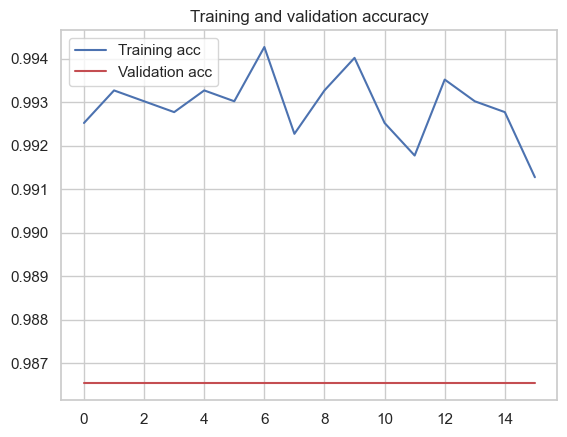

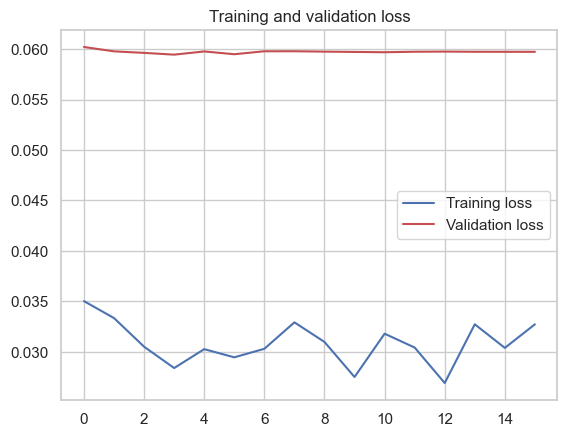

In [226]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [231]:
ypreds1

array([[1.9524028e-04],
       [1.7570643e-05],
       [7.0286412e-03],
       ...,
       [2.5055646e-03],
       [4.1003921e-05],
       [1.4681324e-04]], dtype=float32)

In [232]:
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

ypreds1 = model.predict([test_x, X_test_features], verbose=1)
threshold = 0.5
ypreds1 = (ypreds1 > threshold).astype(int)
print(classification_report(y_test, ypreds1, target_names = ["Ham", "Spam"]))

35/35 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       976
        Spam       0.97      0.93      0.95       139

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



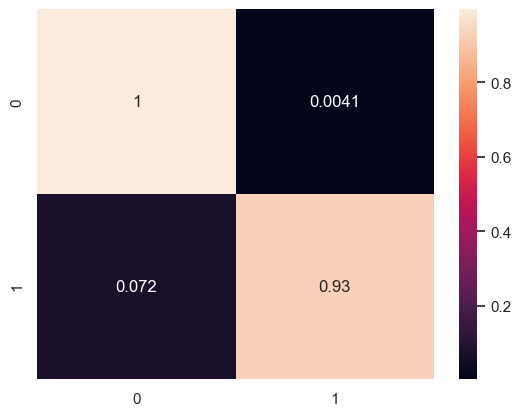

In [238]:
conf_mat = confusion_matrix(y_test, ypreds1)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True)
plt.show()